In [1]:
import pandas as pd
from pathlib import Path
import warnings
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV,GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
# Import the necessary metric
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap
from scipy.stats import mannwhitneyu
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor

#!pip install Boruta
from boruta import BorutaPy

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
dir_path = Path.cwd().parent
dir_path

PosixPath('/Users/alexisroberson/Metabolic_Modeling/Project')

In [3]:
dir_path = Path.cwd().parent

## Deal with Braken
path_braken = dir_path/'Data/SHINE_Bracken_Data/All_SHINE_Braken_tidy_read_data.csv'
braken=pd.read_csv(path_braken)
braken_df = pd.DataFrame(braken)
contamination = braken_df.filter(regex='virus|Homo sapiens') #remove contamination
braken_df = braken_df.drop(columns=contamination.columns)

## Deal with the meta data
path2 = dir_path/'Data/SHINE_Bracken_Data/MP_Data_SHINE_ID_Patient_ID_no_dups.csv'
Meta_data = pd.read_csv(path2)
Meta_data_df = pd.DataFrame(Meta_data)
Meta_data_df =Meta_data_df[(Meta_data_df.duplicated(subset=['SubjectID_child', 'visitlabel'], keep='first'))|(~Meta_data_df.duplicated(subset=['SubjectID_child', 'visitlabel'], keep=False))].reset_index(drop=True)
Meta_data_df

#merge Meta_data_df with Braken read data
Braken_Meta_merge_df = Meta_data_df.merge(braken_df, left_on='run_accession', right_on='sample')
Braken_Meta_merge_df = Braken_Meta_merge_df[(Braken_Meta_merge_df.duplicated(subset=['SubjectID_child', 'visitlabel'], keep='first'))|(~Braken_Meta_merge_df.duplicated(subset=['SubjectID_child', 'visitlabel'], keep=False))].drop(columns='sample').reset_index(drop=True)
Dominant_species_path = pd.read_csv(dir_path/'Data/SHINE_Bracken_Data/Dominant_Species_All_Bracken_G8tr1.csv')
Dominant_species_df = pd.DataFrame(Dominant_species_path)

Braken_meta_dominant_df = Braken_Meta_merge_df[['run_accession','SubjectID_child','visitlabel']+list(Dominant_species_df.columns)] #dataframe of braken dom species with patient id and ERR#


#find Ecoli Coptr samples
Coptr_path = pd.read_csv(dir_path/'Data/SHINE_COPTR_Data/Coptr_tiddy_df.csv')
All_Coptr_df = pd.DataFrame(Coptr_path)
Coptr_Meta_merge_df = Meta_data_df.drop(columns=['SubjectID_child','SHINE_ID','visitlabel','age','age_group']).merge(All_Coptr_df, left_on='run_accession',right_on='Sample')
Coptr_Meta_merge_df.drop(columns='run_accession',inplace=True)

#Get Ecoli samples 
Samples_w_Your_Species_rates = Coptr_Meta_merge_df[Coptr_Meta_merge_df['Escherichia coli']>0]['Sample'] # change to species name that you want 
Coptr_Ecoli_df = Coptr_Meta_merge_df[Coptr_Meta_merge_df['Sample'].isin(Samples_w_Your_Species_rates)]
#Coptr_Ecoli_GR = Coptr_Ecoli_df['Escherichia coli']
#Coptr_Ecoli_GR_df = pd.DataFrame(Coptr_Ecoli_GR)
#Coptr_Ecoli_GR_df.reset_index(drop=True, inplace = True)



#match with Braken
Samples_w_Your_Species_Braken_data_df = Braken_meta_dominant_df[Braken_meta_dominant_df['run_accession'].isin(Samples_w_Your_Species_rates)]
#put together 
All_Coptr_E_Coli_GR = Coptr_Ecoli_df[['Sample','Escherichia coli']]  #dataframe of sample number and Ecoli Growth rate 
our_coptr_EC_GR = All_Coptr_E_Coli_GR[All_Coptr_E_Coli_GR['Sample'].isin(Samples_w_Your_Species_Braken_data_df['run_accession'])] ##make sure we get Coptr data(ecoli gr samples) that are in our braken data 

Full_data = Samples_w_Your_Species_Braken_data_df.merge(our_coptr_EC_GR, left_on = 'run_accession', right_on='Sample').drop(columns='Sample').rename(columns={'Escherichia coli_y':'Ecoli_GR'})

Full_data_copy = Full_data.copy()
psuedocount = 0.1
Full_data_copy = Full_data_copy.applymap(lambda x: psuedocount if x ==0 else x)

Full_data_copy.drop(columns= ['Escherichia phage vB_EcoS-Ro145c2YLVW','Escherichia phage vB_EcoS_fFiEco03','Escherichia phage 26','Escherichia phage SZH-1','Salmonella phage vB_SAg-RPN213'],inplace=True)

Full_data_copy.columns = Full_data_copy.columns.str.replace(r'[^A-Za-z0-9_]', '', regex=True)
Full_data_copy.columns = Full_data_copy.columns.str.replace(' ', '_')
Full_data_copy = Full_data_copy.loc[:, ~Full_data_copy.columns.duplicated()]

#psuedocount = 0.1
#Samples_w_Your_Species_Braken_w_psuedo = Samples_w_Your_Species_Braken_data_df_copy.applymap(lambda x: psuedocount if x ==0 else x)
#Samples_w_Your_Species_Braken_data_a

In [ ]:
Full_data_copy['Ecoli_GR']

In [ ]:
Full_data['Escherichia coli_x']

In [ ]:
# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Biflong_GR'])
# Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Biflong_GR']

#indices = Full_data_copy.index
X.shape
#X_Tmp, X_Test, Y_Tmp, Y_Test, train_indices,test_indices = train_test_split(X, Y,indices, test_size=0.2, train_size=0.8, random_state=1, shuffle=True)
#X_Tmp

In [ ]:
train_indices

In [ ]:
indices = Full_data_copy.index
indices

In [ ]:
def Random_split(data,number):
    # Separate the data into features and target (X and Y)
    X = data.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Biflong_GR'])
    # Target variable (Ecoli_Growth_rate)
    Y = data['Biflong_GR']
    #index of data
    indices = data.index

    
    # Set up lists for model performance
    best_models = []   
    validation_score_list = []
    test_scores_list = []
    r2_list = []
    
    # Set up lists for the random model
    random_best_models = []
    random_valid_score_list = []
    random_test_scores_list = []
    random_r2_list = []
    warnings.filterwarnings("ignore", category=UserWarning)


    # Define hyperparameters grid for the real model
    param_grid = {
        'num_leaves': [2,4,8,10,16,15,20,24,26,30,32],  # Range from 2 to 24 with a step of 2
        'max_depth': np.arange(2, 16),  
        'min_split_gain': np.arange(0,.5,.01),
        'learning_rate': np.arange(0.001, 0.053,.001), #np.arange(0.01, 0.07, .005),  # 10 evenly spaced values between 0.01 and 0.1
        'n_estimators': np.arange(200, 600, 50),  # Range from 50 to 200 with a step of 50'num_leaves': [2,4,6,8,10,12,14,16,24],
        'min_child_samples': np.arange(5,20,1),
        'subsample': [0.8],
        'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        'subsample_freq': [2],
        'reg_alpha': np.arange(0,.25,0.01),
        'reg_lambda': np.arange(0,.25,0.01),
        }
    # Goal: Shuffle data and randomly split Tmp and test data 10 times
    for i in range(1, number+1):
        # Shuffle and randomly split into Tmp and Test data 
        X_Tmp, X_Test, Y_Tmp, Y_Test, Tmp_indices, Test_indices = train_test_split(X, Y, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True)
        
        # Permute the target variable for the random model
        Y_tmp_perm = np.random.permutation(Y_Tmp)

        
        # Make our real model
        lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')

        # Set up GridSearchCV for the real model
        random_search = RandomizedSearchCV(
            estimator=lgb_model,
            param_distributions=param_grid,
            n_iter=600,
            scoring='neg_mean_squared_error',
            cv=5,
            verbose=0,
            n_jobs=-1)
        

        
        # Fit the real model
        random_search.fit(X_Tmp, Y_Tmp)
        best_models.append(random_search.best_estimator_)
        
        # Compute SHAP values for the real model
        explainer_real = shap.Explainer(best_models[-1])  # Create a SHAP explainer
        shap_values_real = explainer_real(X_Test)  # Calculate SHAP values



        #shap_results_data_to_save = {
        #'shap_values': shap_values_real.values,    # these are SHAP values for each feature for the test set
        #'test_indices': Test_indices   # these are Test indices used in this split
        #}
        shap_results_data_to_save = {
        'shap_values': shap_values_real,    # these are SHAP values for each feature for the test set
        'test_indices': Test_indices   # these are Test indices used in this split
        }
        np.save(f'Biflong_Randomsplit_shap_data_round_{i}.npy',shap_results_data_to_save)
        np.save(f'Biflong_Randomsplit_bestmodel_round_{i}.npy',best_models)
        # Save SHAP values for the real model
        #np.save(f'RandomSplit_shap_values_real_round_{i}.npy', shap_values_real.values)  # Save SHAP values
        # save the actual data for inspection
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        # save the test indexes
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        
        # Save summary plot for the real model
        plt.figure()
        shap.summary_plot(shap_values_real, X_Test, show=False)
        plt.title(f'Biflong_RandomSplit SHAP Summary Plot - Real Model - Round {i}')
        plt.savefig(f'Biflong_Random_split_shap_summary_real_round_{i}.png')
        plt.close()

        # Collect scores for the real model
        Y_pred_real = random_search.best_estimator_.predict(X_Test)
        testing_mse = mean_squared_error(Y_Test, Y_pred_real)
        test_scores_list.append(testing_mse)
        r2 = r2_score(Y_Test, Y_pred_real)
        r2_list.append(r2)
        validation_score = random_search.best_score_
        validation_score_list.append(validation_score)
        Residuals = Y_Test - Y_pred_real

        # Make our random model
        random_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')
        
        # Set up GridSearchCV for the random model
        random_search_rm = RandomizedSearchCV(
            estimator=random_model,
            param_distributions=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            verbose=0,
            n_jobs=-1
        )
        
        # Fit the random model
        random_search_rm.fit(X_Tmp, Y_tmp_perm)
        random_best_models.append(random_search_rm.best_estimator_)
        
        # Collect scores for the random model
        random_Y_pred = random_search_rm.best_estimator_.predict(X_Test)
        random_testing_mse = mean_squared_error(Y_Test, random_Y_pred)
        random_test_scores_list.append(random_testing_mse)
        random_r2 = r2_score(Y_Test, random_Y_pred)
        random_r2_list.append(random_r2)
        random_validation_score = random_search_rm.best_score_
        random_valid_score_list.append(random_validation_score)
        

        # Time of subplots!!!!
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

        # Plot for the real model
        axs[0].scatter(Y_Test, Y_pred_real, color='blue', label='Lightgbm', alpha=0.6)
        axs[0].scatter(Y_Test, random_Y_pred, color='orange', label='Random Model', alpha=0.6)
        axs[0].plot([Y_Test.min(), Y_Test.max()], [Y_Test.min(), Y_Test.max()], 'r--', lw=2)
        axs[0].set_title(f'Real Model - Round {i}')
        axs[0].set_xlabel('Actual Values')
        axs[0].set_ylabel('Predicted Values')
        axs[0].legend()
        axs[0].axis('equal')  # Set equal scaling

        # Plot for the real model
        axs[1].scatter(Y_pred_real,Residuals, color='blue', label='Residuals', alpha=0.6)
        axs[1].axhline(y=0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
        axs[1].set_title(f'Real Model - Round {i}')
        axs[1].set_xlabel('Predicted Values')
        axs[1].set_ylabel('Residuals (Y_test - Y_pred)')
        axs[1].legend()
        axs[1].axis('equal')  # Set equal scaling
        axs[1].grid()

        # Show the plot
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.savefig(f'Biflong_RandomSplit_plot_round_{i}.png')  # Save each plot as an image
        plt.show()
        plt.close()
        

    #keep stats data work and model eval stats
    columns= np.arange(1,number+1,1)
    RS_table = pd.DataFrame([validation_score_list,test_scores_list, r2_list],index=['validation_score','test_score','R2'],columns=columns)
    Random_RS_model_table = pd.DataFrame([random_valid_score_list,random_test_scores_list,random_r2_list],index=['validation_score','test_score','R2'],columns=columns)
    RS_table.to_csv('RS_table.csv')
    Random_RS_model_table.to_csv('Random_RS_model_table.csv')
    
   
    return best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list
    

In [ ]:
 # Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Biflong_GR'])
# Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Biflong_GR']

    
param_grid = {
    'num_leaves': [2,4,8,10,16,15,20,24,26,30,32],  # Range from 2 to 24 with a step of 2
        #'max_depth': np.arange(2, 16),  
        #'min_split_gain': np.arange(0,.5,.01),
        #'learning_rate': np.arange(0.001, 0.053,.001), #np.arange(0.01, 0.07, .005),  # 10 evenly spaced values between 0.01 and 0.1
        #'n_estimators': np.arange(200, 600, 50),  # Range from 50 to 200 with a step of 50'num_leaves': [2,4,6,8,10,12,14,16,24],
        #'min_child_samples': np.arange(5,20,1),
        #'subsample': [0.8],
        #'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        #'subsample_freq': [2],
        #'reg_alpha': np.arange(0,.25,0.01),
        #'reg_lambda': np.arange(0,.25,0.01),
        }

X_Tmp, X_Test, Y_Tmp, Y_Test, Tmp_indices, Test_indices = train_test_split(X, Y, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True)
        
        

        
        # Make our real model
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')

        # Set up GridSearchCV for the real model
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=600,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=0,
    n_jobs=-1)
        

        
        # Fit the real model
        random_search.fit(X_Tmp, Y_Tmp)
        best_models.append(random_search.best_estimator_)
        
        # Compute SHAP values for the real model
        explainer_real = shap.Explainer(best_models[-1])  # Create a SHAP explainer
        shap_values_real = explainer_real(X_Test)  # Calculate SHAP values



        #shap_results_data_to_save = {
        #'shap_values': shap_values_real.values,    # these are SHAP values for each feature for the test set
        #'test_indices': Test_indices   # these are Test indices used in this split
        #}
        shap_results_data_to_save = {
        'shap_values': shap_values_real,    # these are SHAP values for each feature for the test set
        'test_indices': Test_indices   # these are Test indices used in this split
        }
        np.save(f'Biflong_Randomsplit_shap_data_round_{i}.npy',shap_results_data_to_save)
        np.save(f'Biflong_Randomsplit_bestmodel_round_{i}.npy',best_models)
        # Save SHAP values for the real model
        #np.save(f'RandomSplit_shap_values_real_round_{i}.npy', shap_values_real.values)  # Save SHAP values
        # save the actual data for inspection
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        # save the test indexes
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        
        # Save summary plot for the real model
        plt.figure()
        shap.summary_plot(shap_values_real, X_Test, show=False)
        plt.title(f'Biflong_RandomSplit SHAP Summary Plot - Real Model - Round {i}')
        plt.savefig(f'Biflong_Random_split_shap_summary_real_round_{i}.png')
        plt.close()

        # Collect scores for the real model
        Y_pred_real = random_search.best_estimator_.predict(X_Test)
        testing_mse = mean_squared_error(Y_Test, Y_pred_real)
        test_scores_list.append(testing_mse)
        r2 = r2_score(Y_Test, Y_pred_real)
        r2_list.append(r2)
        validation_score = random_search.best_score_
        validation_score_list.append(validation_score)
        Residuals = Y_Test - Y_pred_real

        # Make our random model
        random_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')
        
        # Set up GridSearchCV for the random model
        random_search_rm = RandomizedSearchCV(
            estimator=random_model,
            param_distributions=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            verbose=0,
            n_jobs=-1
        )
        
        # Fit the random model
        random_search_rm.fit(X_Tmp, Y_tmp_perm)
        random_best_models.append(random_search_rm.best_estimator_)
        
        # Collect scores for the random model
        random_Y_pred = random_search_rm.best_estimator_.predict(X_Test)
        random_testing_mse = mean_squared_error(Y_Test, random_Y_pred)
        random_test_scores_list.append(random_testing_mse)
        random_r2 = r2_score(Y_Test, random_Y_pred)
        random_r2_list.append(random_r2)
        random_validation_score = random_search_rm.best_score_
        random_valid_score_list.append(random_validation_score)
        

        # Time of subplots!!!!
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

        # Plot for the real model
        axs[0].scatter(Y_Test, Y_pred_real, color='blue', label='Lightgbm', alpha=0.6)
        axs[0].scatter(Y_Test, random_Y_pred, color='orange', label='Random Model', alpha=0.6)
        axs[0].plot([Y_Test.min(), Y_Test.max()], [Y_Test.min(), Y_Test.max()], 'r--', lw=2)
        axs[0].set_title(f'Real Model - Round {i}')
        axs[0].set_xlabel('Actual Values')
        axs[0].set_ylabel('Predicted Values')
        axs[0].legend()
        axs[0].axis('equal')  # Set equal scaling

        # Plot for the real model
        axs[1].scatter(Y_pred_real,Residuals, color='blue', label='Residuals', alpha=0.6)
        axs[1].axhline(y=0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
        axs[1].set_title(f'Real Model - Round {i}')
        axs[1].set_xlabel('Predicted Values')
        axs[1].set_ylabel('Residuals (Y_test - Y_pred)')
        axs[1].legend()
        axs[1].axis('equal')  # Set equal scaling
        axs[1].grid()

        # Show the plot
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.savefig(f'Biflong_RandomSplit_plot_round_{i}.png')  # Save each plot as an image
        plt.show()
        plt.close()
        

    #keep stats data work and model eval stats
    columns= np.arange(1,number+1,1)
    RS_table = pd.DataFrame([validation_score_list,test_scores_list, r2_list],index=['validation_score','test_score','R2'],columns=columns)
    Random_RS_model_table = pd.DataFrame([random_valid_score_list,random_test_scores_list,random_r2_list],index=['validation_score','test_score','R2'],columns=columns)
    RS_table.to_csv('RS_table.csv')
    Random_RS_model_table.to_csv('Random_RS_model_table.csv')
    
   
    return best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list
    

In [ ]:
best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list = Random_split(Full_data_copy,5)
number=5
columns= np.arange(1,number+1,1)
RS_table = pd.DataFrame([validation_score_list,test_scores_list, r2_list],index=['validation_score','test_score','R2'],columns=columns)
Random_RS_model_table = pd.DataFrame([random_valid_score_list,random_test_scores_list,random_r2_list],index=['validation_score','test_score','R2'],columns=columns)


In [ ]:
# Extracting validation scores and test scores for both models
validation_scores = RS_table.loc['validation_score'].values
validation_scores = [-score for score in validation_score_list]
random_validation_scores = Random_RS_model_table.loc['validation_score'].values
random_validation_scores = [-score for score in random_valid_score_list]
test_scores = RS_table.loc['test_score'].values
random_test_scores = Random_RS_model_table.loc['test_score'].values

# Perform Mann-Whitney U test on validation scores
u_statistic_validation, p_value_validation = mannwhitneyu(validation_scores, random_validation_scores)

# Perform Mann-Whitney U test on test scores
u_statistic_test, p_value_test = mannwhitneyu(test_scores, random_test_scores)

# Print results
print(f'Mann-Whitney U Test on Validation Scores: U-statistic = {u_statistic_validation}, p-value = {p_value_validation}')
print(f'Mann-Whitney U Test on Test Scores: U-statistic = {u_statistic_test}, p-value = {p_value_test}')

In [ ]:
# Prepare the data for visualization
data = {
    'Model Type': ['LightGBM'] * len(validation_scores) + ['Random Model'] * len(random_validation_scores),
    'Validation Score': np.concatenate([validation_scores, random_validation_scores]),
    'Test Score': np.concatenate([test_scores, random_test_scores])
}

# Create a DataFrame
scores_df = pd.DataFrame(data)

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create a boxplot for Validation Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Model Type', y='Validation Score', data=scores_df)
plt.title('Validation Data Performance')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model Type')

# Create a boxplot for Test Scores
plt.subplot(1, 2, 2)
sns.boxplot(x='Model Type', y='Test Score', data=scores_df)
plt.title('Performance on Testing Data')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model Type')

plt.tight_layout()
plt.show()


In [ ]:
# Create a violin plot for Validation Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='Model Type', y='Validation Score', data=scores_df)
plt.title('Validation Scores Violin Plot')
plt.ylabel('Validation Score')
plt.xlabel('Model Type')

# Create a violin plot for Test Scores
plt.subplot(1, 2, 2)
sns.violinplot(x='Model Type', y='Test Score', data=scores_df)
plt.title('Test Scores Violin Plot')
plt.ylabel('Test Score')
plt.xlabel('Model Type')

plt.tight_layout()
plt.show()

### Shap Plot Combined

In [ ]:

#make list for the directory paths of each shap value result library
paths = []

# make list for the actual shap value result
shap_result = []
number=5
for n in range(1,number+1):
    path = dir_path / f'Scripts_for_ML/Randomsplit_shap_data_round_{n}.npy'  #this is the directory to where the shap data is May need to change
    paths.append(path)
    #append the shap data to list
    loaded_data = np.load(path,allow_pickle=True).item()
    shap_result.append(loaded_data)

# Initialize the combined SHAP dictionary with our first result
combined_shap_results = {
    "values": shap_result[0]['shap_values'].values,
    "data": shap_result[0]['shap_values'].data,
    "base_values": shap_result[0]['shap_values'].base_values
}

# Iterate over the the other SHAP results to stack them
for i in range(1, len(shap_result)):
    combined_shap_results["values"] = np.vstack((combined_shap_results["values"], shap_result[i]['shap_values'].values))
    combined_shap_results["data"] = np.vstack((combined_shap_results["data"], shap_result[i]['shap_values'].data))
    combined_shap_results["base_values"] = np.concatenate((combined_shap_results["base_values"], shap_result[i]['shap_values'].base_values))

feature_names = loaded_data['shap_values'].feature_names 
#Plot our results
shap.summary_plot(
    combined_shap_results["values"],  # SHAP values
    combined_shap_results["data"],    # Corresponding feature data
    feature_names=feature_names
)

In [ ]:
## Turn the shap values and feature values in dataframes with the feature names so we can plot dependence plots

combined_shap_results['values']
values_df = pd.DataFrame(combined_shap_results['values'],columns= feature_names)
feature_values_df = pd.DataFrame(combined_shap_results['data'],columns=feature_names)
feature_values_df

fig, axs = plt.subplots(2, 3, figsize=(12, 5))

## make plots
axs[0,0].scatter(feature_values_df['Shigellaflexneri'],values_df['Shigellaflexneri'],c='blue')
#axs[0,0].set_title('')
axs[0,0].set_xlabel('Shigella Flexneri Read Counts')
axs[0,0].set_ylabel('Shap Values for Shigella Flexneri')

axs[0,1].scatter(feature_values_df['Shigellasonnei'],values_df['Shigellasonnei'],c='blue')
#axs[0,1].set_title('')
axs[0,1].set_xlabel('Shigella Sonnei Read Counts')
axs[0,1].set_ylabel('Shap Values for Shigella Sonnei')

axs[0,2].scatter(feature_values_df['Escherichiacoli_x'],values_df['Escherichiacoli_x'],c='blue')
#axs[0,2].set_title('')
axs[0,2].set_xlabel('Escherichia Coli Read Counts')
axs[0,2].set_ylabel('Shap Values for Escherichia Coli')

axs[1,0].scatter(feature_values_df['Eggerthellalenta'],values_df['Eggerthellalenta'],c='blue')
#axs[1,0].set_title('')
axs[1,0].set_xlabel('Eggerthellalenta Read Counts')
axs[1,0].set_ylabel('Shap Values for Eggerthellalenta')

axs[1,1].scatter(feature_values_df['Klebsiellapneumoniae'],values_df['Klebsiellapneumoniae'],c='blue')
#axs[1,1].set_title('')
axs[1,1].set_xlabel('Klebsiella Pneumoniae Read Counts')
axs[1,1].set_ylabel('Shap Values for Klebsiellapneumoniae')

axs[1,2].scatter(feature_values_df['CandidatusCampylobacterinfans'],values_df['CandidatusCampylobacterinfans'],c='blue')
#axs[1,2].set_title('')
axs[1,2].set_xlabel('Candidatus Campylobacterinfans Read Counts')
axs[1,2].set_ylabel('Shap Values for Candidatus Campylobacterinfans')

plt.tight_layout() 
#plt.scatter(feature_values_df['Campylobacterjejuni'],values_df['Campylobacterjejuni'])

In [ ]:
## This is just to look at the parameters for the model 

path2 = dir_path / f'Scripts_for_ML/RS_1500_5iterations/Randomsplit_bestmodel_round_5.npy'

loaded_data2 = np.load(path2,allow_pickle=True)
loaded_data2

#loaded_data.get_params()

To do:
Spearman correlation between feature value and shap value in Shigella flex
Spearman correlation for all the features and its shap value
Try lasso

Go down ranked species of coptr data 
Create table of the data sets with pubs

### PCoA for feature engineering/Selection

In [ ]:
##Grab the data
# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
# Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Ecoli_GR']

##We need to make a distance matrix
distance_matrix = beta_diversity(
    metric = 'braycurtis',
    counts = X
    ids = X.index
)

#Do PCoA
PCoA_result = pcoa(distance_matrix)







Try Lasso regression model or Elastic net?

### Boruta 

In [ ]:
# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
# Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Ecoli_GR']
indices = Full_data_copy.index

X_Tmp, X_Test, Y_Tmp, Y_Test, Tmp_indices, Test_indices = train_test_split(X, Y, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True)

#Feature selection inner cv 
rfr = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfr, n_estimators='auto', verbose=0, random_state=1)
boruta_selector.fit(np.array(X_Tmp), np.array(Y_Tmp))
        





In [ ]:
print("No. of significant features: ", boruta_selector.n_features_) 

select_features = pd.DataFrame({'Feature':list(X.columns),
                               'Ranking':boruta_selector.ranking_}).sort_values(by='Ranking')

#Get top and middle top features and make X_tmp matrix of only those features
Top_feature_columns = select_features[select_features['Ranking']==1].index   #get columns of top features(for sure)
median_ranking = np.median(boruta_selector.ranking_)
middle_features = select_features[(select_features['Ranking']<median_ranking)|(select_features['Ranking']<median_ranking+3)]
middle_features_columns = middle_features.index  #get features that were kinda top /from middle distribtion
X_Tmp_w_top_features = X_Tmp.iloc[:,Top_feature_columns]
X_Tmp_w_middle_features = X_Tmp.iloc[:,Tmiddle_features_columns]

In [ ]:
median_ranking = np.median(boruta_selector.ranking_)
middle_features = select_features[(select_features['Ranking']<median_ranking)&(select_features['Ranking']>median_ranking+1)]

middle_features 
#median_ranking = np.median(boruta_selector.ranking_)

In [ ]:
select_features[(select_features['Ranking']<median_ranking)|(select_features['Ranking']<median_ranking+3)]

In [ ]:
def Random_split(data,number):
    # Separate the data into features and target (X and Y)
    X = data.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
    # Target variable (Ecoli_Growth_rate)
    Y = data['Ecoli_GR']
    #index of data
    indices = data.index

    
    # Set up lists for model performance
    best_models = []   
    validation_score_list = []
    test_scores_list = []
    r2_list = []
    
    # Set up lists for the random model
    random_best_models = []
    random_valid_score_list = []
    random_test_scores_list = []
    random_r2_list = []
    warnings.filterwarnings("ignore", category=UserWarning)


    # Define hyperparameters grid for the real model
    param_grid = {
        'num_leaves':[2,4,8,10,16,15,20,24,26,30,32,36],  # Range from 2 to 24 with a step of 2
        'max_depth': np.arange(2, 16),  
        'min_split_gain': np.arange(0,.5,.01),
        'learning_rate': np.arange(0.001, 0.053,.001), #np.arange(0.01, 0.07, .005),  # 10 evenly spaced values between 0.01 and 0.1
        'n_estimators': np.arange(200, 600, 50),  # Range from 50 to 200 with a step of 50'num_leaves': [2,4,6,8,10,12,14,16,24],
        'min_child_samples': np.arange(5,20,1),
        #'subsample': [0.8],
        #'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        #'subsample_freq': [2],
        'reg_alpha': np.arange(0,.25,0.01),
        'reg_lambda': np.arange(0,.25,0.01),
        }
    # Goal: Shuffle data and randomly split Tmp and test data 10 times
    for i in range(1, number+1):
        # Shuffle and randomly split into Tmp and Test data 
        X_Tmp, X_Test, Y_Tmp, Y_Test, Tmp_indices, Test_indices = train_test_split(X, Y, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True)
        
        # Permute the target variable for the random model
        Y_tmp_perm = np.random.permutation(Y_Tmp)

        #Feature selection inner cv 
        rfr = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=5)
        boruta_selector = BorutaPy(rfr, n_estimators='auto', verbose=0, random_state=1)
        boruta_selector.fit(np.array(X_Tmp), np.array(Y_Tmp))

        select_features = pd.DataFrame({'Feature':list(X.columns),
                               'Ranking':boruta_selector.ranking_}).sort_values(by='Ranking')

        #Get top and middle top features and make X_tmp matrix of only those features
        Top_feature_columns = select_features[select_features['Ranking']==1].index   #get columns of top features(for sure)
        median_ranking = np.median(boruta_selector.ranking_)
        middle_features = select_features[(select_features['Ranking']<median_ranking)|(select_features['Ranking']<median_ranking+3)]
        middle_features_columns = middle_features.index  #get features that were kinda top /from middle distribtion
        X_Tmp_w_top_features = X_Tmp.iloc[:,Top_feature_columns]
        X_Tmp_w_middle_features = X_Tmp.iloc[:,middle_features_columns]
        X_Test_w_middle_features = X_Test.iloc[:,middle_features_columns]

        X_Tmp_w_top_features.to_csv(f"Top_features_{i}.csv")
        X_Tmp_w_middle_features.to_csv(f"Middle_features_{i}.csv")


        # Make our real model
        lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')

        # Set up GridSearchCV for the real model
        random_search = RandomizedSearchCV(
            estimator=lgb_model,
            param_distributions=param_grid,
            n_iter=3000,
            scoring='neg_mean_squared_error',
            cv=10,
            verbose=0,
            n_jobs=-1)
        

        
        # Fit the real model
        random_search.fit(X_Tmp_w_middle_features, Y_Tmp)
        best_models.append(random_search.best_estimator_)
        
        # Compute SHAP values for the real model
        explainer_real = shap.Explainer(best_models[-1])  # Create a SHAP explainer
        shap_values_real = explainer_real(X_Test_w_middle_features)  # Calculate SHAP values



        #shap_results_data_to_save = {
        #'shap_values': shap_values_real.values,    # these are SHAP values for each feature for the test set
        #'test_indices': Test_indices   # these are Test indices used in this split
        #}
        shap_results_data_to_save = {
        'shap_values': shap_values_real,    # these are SHAP values for each feature for the test set
        'test_indices': Test_indices   # these are Test indices used in this split
        }
        np.save(f'E_Coli_Randomsplit_shap_data_round_{i}.npy',shap_results_data_to_save)
        np.save(f'E_Coli_Randomsplit_bestmodel_round_{i}.npy',best_models)
        # Save SHAP values for the real model
        #np.save(f'RandomSplit_shap_values_real_round_{i}.npy', shap_values_real.values)  # Save SHAP values
        # save the actual data for inspection
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        # save the test indexes
        #np.save(f'shap_data_round_{i}.npy', X_Test)
        
        # Save summary plot for the real model
        plt.figure()
        shap.summary_plot(shap_values_real, X_Test, show=False)
        plt.title(f'E_Coli_RandomSplit SHAP Summary Plot - Real Model - Round {i}')
        plt.savefig(f'E_Coli_Random_split_shap_summary_real_round_{i}.png')
        plt.close()

        # Collect scores for the real model
        Y_pred_real = random_search.best_estimator_.predict(X_Test)
        testing_mse = mean_squared_error(Y_Test, Y_pred_real)
        test_scores_list.append(testing_mse)
        r2 = r2_score(Y_Test, Y_pred_real)
        r2_list.append(r2)
        validation_score = random_search.best_score_
        validation_score_list.append(validation_score)
        Residuals = Y_Test - Y_pred_real

        # Make our random model
        random_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression')
        
        # Set up GridSearchCV for the random model
        random_search_rm = RandomizedSearchCV(
            estimator=random_model,
            param_distributions=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            verbose=0,
            n_jobs=-1
        )
        
        # Fit the random model
        random_search_rm.fit(X_Tmp, Y_tmp_perm)
        random_best_models.append(random_search_rm.best_estimator_)
        
        # Collect scores for the random model
        random_Y_pred = random_search_rm.best_estimator_.predict(X_Test)
        random_testing_mse = mean_squared_error(Y_Test, random_Y_pred)
        random_test_scores_list.append(random_testing_mse)
        random_r2 = r2_score(Y_Test, random_Y_pred)
        random_r2_list.append(random_r2)
        random_validation_score = random_search_rm.best_score_
        random_valid_score_list.append(random_validation_score)
        

        # Time of subplots!!!!
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

        # Plot for the real model
        axs[0].scatter(Y_Test, Y_pred_real, color='blue', label='Lightgbm', alpha=0.6)
        axs[0].scatter(Y_Test, random_Y_pred, color='orange', label='Random Model', alpha=0.6)
        axs[0].plot([Y_Test.min(), Y_Test.max()], [Y_Test.min(), Y_Test.max()], 'r--', lw=2)
        axs[0].set_title(f'Real Model - Round {i}')
        axs[0].set_xlabel('Actual Values')
        axs[0].set_ylabel('Predicted Values')
        axs[0].legend()
        axs[0].axis('equal')  # Set equal scaling

        # Plot for the real model
        axs[1].scatter(Y_pred_real,Residuals, color='blue', label='Residuals', alpha=0.6)
        axs[1].axhline(y=0, color='red', linestyle='--', lw=2)  # Horizontal line at 0
        axs[1].set_title(f'Real Model - Round {i}')
        axs[1].set_xlabel('Predicted Values')
        axs[1].set_ylabel('Residuals (Y_test - Y_pred)')
        axs[1].legend()
        axs[1].axis('equal')  # Set equal scaling
        axs[1].grid()

        # Show the plot
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.savefig(f'E_Coli_RandomSplit_plot_round_{i}.png')  # Save each plot as an image
        plt.show()
        plt.close()
        

    #keep stats data work and model eval stats
    columns= np.arange(1,number+1,1)
    RS_table = pd.DataFrame([validation_score_list,test_scores_list, r2_list],index=['validation_score','test_score','R2'],columns=columns)
    Random_RS_model_table = pd.DataFrame([random_valid_score_list,random_test_scores_list,random_r2_list],index=['validation_score','test_score','R2'],columns=columns)
    RS_table.to_csv('RS_table.csv')
    Random_RS_model_table.to_csv('Random_RS_model_table.csv')
    
   
    return best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list
    

In [ ]:
best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list = Random_split(Full_data_copy,1)
#number=3
#columns= np.arange(1,number+1,1)
#RS_table = pd.DataFrame([validation_score_list,test_scores_list, r2_list],index=['validation_score','test_score','R2'],columns=columns)
#Random_RS_model_table = pd.DataFrame([random_valid_score_list,random_test_scores_list,random_r2_list],index=['validation_score','test_score','R2'],columns=columns)


In [ ]:
# List of files to load
files = ['shap_values_split_0.npy', 'shap_values_split_1.npy', 'shap_values_split_2.npy']
shap_values_list = []
test_indices_list = []

# Load each file and collect SHAP values
for file in files:
    loaded_data = np.load(file, allow_pickle=True).item()
    shap_values_list.append(loaded_data['shap_values'])
    test_indices_list.append(loaded_data['test_indices'])

# Stack SHAP values to create a 3D array (splits, samples, features)
shap_values_stack = np.stack(shap_values_list)

# Average SHAP values across the first axis (across different splits)
average_shap_values = np.mean(shap_values_stack, axis=0)  # Shape will be (151, 257)

# Print shape of averaged SHAP values
print("Average SHAP Values Shape:", average_shap_values.shape)  # Should be (151, 257)

In [ ]:
#find the common indices across all our rounds
    common_test_indices = set(shap_result[0]['test_indices'])
    for d in shap_result[1:]:
        common_test_indices &= set(d['test_indices'])

    averaged_shap_dict = {} # Initialize a dictionary to store averaged SHAP values for each common index

    for index in common_test_indices:
        shap_values_for_index = [d['shap_values'][list(d['test_indices']).index(index)] for d in shap_result]

        average_shap_values = np.mean(shap_values_for_index,axis=0)
        averaged_shap_dict[index] = average_shap_values  # Store the result in the dictionary with the index as the key

    averaged_shap_df = pd.DataFrame.from_dict(averaged_shap_dict,orient='index')

    plt.figure()
    shap.summary_plot(averaged_shap_df, X.iloc[list(common_test_indices)],feature_names=X.columns, show=False)
    plt.title(f'RandomSplit Average SHAP Summary Plot')
    plt.savefig(f'RandomSplit_Average_Shap_Plot.png')
    plt.close()
    
    return best_models, validation_score_list, test_scores_list, r2_list, random_best_models, random_valid_score_list, random_test_scores_list, random_r2_list
    

In [ ]:
Full_data_copy

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np
# Calculate the performance on the test data (MSE or R2)
from sklearn.metrics import mean_squared_error, r2_score


# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
    # Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Ecoli_GR']
# Prepare your features and target variable
#X = Full_data_copy.drop(columns=['Ecoli_GR'])
#y = Full_data_copy['Ecoli_GR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up the SVM with RBF kernel
svm_rbf = SVR(kernel='rbf')

# Define the parameter grid for gamma and C
param_grid = {
    'C': [0.001,.005, 0.1,.5,.7, 1, 10, 100, 1000],  # C from 0.001 to 1000
    'gamma': [1000, 1, 0.1, 0.01, 0.001, 0.0001]  # gamma values, scale and auto are options
}

# Perform GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm_rbf, param_grid, cv=10, scoring='mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model (with optimized hyperparameters)
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate the performance on the test data (MSE or R2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")


InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'explained_variance', 'neg_median_absolute_error', 'neg_brier_score', 'positive_likelihood_ratio', 'f1', 'mutual_info_score', 'precision_samples', 'r2', 'roc_auc_ovr', 'f1_samples', 'neg_mean_gamma_deviance', 'adjusted_rand_score', 'roc_auc_ovo_weighted', 'precision', 'accuracy', 'adjusted_mutual_info_score', 'balanced_accuracy', 'recall_weighted', 'roc_auc_ovr_weighted', 'recall_samples', 'top_k_accuracy', 'neg_negative_likelihood_ratio', 'precision_micro', 'jaccard_macro', 'recall_macro', 'homogeneity_score', 'neg_mean_squared_log_error', 'roc_auc_ovo', 'neg_mean_poisson_deviance', 'average_precision', 'f1_weighted', 'v_measure_score', 'f1_micro', 'fowlkes_mallows_score', 'max_error', 'precision_weighted', 'precision_macro', 'recall', 'jaccard', 'jaccard_weighted', 'neg_root_mean_squared_error', 'jaccard_samples', 'neg_mean_squared_error', 'normalized_mutual_info_score', 'matthews_corrcoef', 'recall_micro', 'rand_score', 'f1_macro', 'neg_mean_absolute_percentage_error', 'neg_log_loss', 'completeness_score', 'jaccard_micro', 'roc_auc', 'neg_mean_absolute_error'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'mean_squared_error' instead.

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
    # Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Ecoli_GR']
# Prepare your features and target variable
#X = Full_data_copy.drop(columns=['Ecoli_GR'])
#y = Full_data_copy['Ecoli_GR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_jobs=-1,n_estimators=1000, max_depth=5, random_state=1)
boruta = BorutaPy(rf_regressor, verbose=0,n_estimators='auto', random_state=1)
boruta.fit(X_train.values, y_train.values)  # Fit Boruta to your training data

# Get the selected features
selected_features = X_train.columns[boruta.support_].tolist()
print(f"Selected features by Boruta: {selected_features}")

# Filter the selected features from the original dataset
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Standardize the data (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Set up and fit the SVM model
svm = SVR(kernel='rbf')
svm.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = svm.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")


In [7]:
Full_data_copy


,run_accession,SubjectID_child,visitlabel,Acidaminococcusfermentans,Acidaminococcusintestini,Acinetobacterbaumannii,Acinetobacterindicus,AcinetobacterspSCLZS86,Acinetobactertowneri,Acinetobactervariabilis,...,VeillonellaspS1202513,Vescimonascoprocola,Vescimonasfastidiosa,Weissellaconfusa,Wujiachipingensis,Clostridiuminnocuum,Clostridiumscindens,Ruminococcuslactaris,Ruminococcustorques,Ecoli_GR
0,ERR10901421,020-30471-1-7,M01,0.1,0.1,194.0,0.1,88.0,51.0,87.0,...,17704.0,0.1,0.1,19.0,0.1,59.0,72.0,51.0,61.0,0.902055
1,ERR10901327,020-13118-1-6,M03,129.0,1800.0,0.1,0.1,0.1,0.1,0.1,...,4202.0,29.0,18.0,0.1,0.1,24.0,30.0,0.1,19.0,0.651277
2,ERR10901309,020-35873-1-4,M01,27.0,0.1,516.0,1884.0,359.0,467.0,303.0,...,185.0,13.0,12.0,14.0,13.0,619.0,1237.0,55.0,295.0,0.650389
3,ERR10901412,020-32940-1-4,M06,30250.0,629.0,90.0,0.1,32.0,49.0,181.0,...,36.0,141.0,112.0,0.1,67.0,47301.0,4025.0,463.0,783.0,0.484738
4,ERR10901419,020-03098-1-6,M01,0.1,0.1,0.1,0.1,0.1,65.0,0.1,...,179.0,0.1,0.1,0.1,0.1,0.1,107.0,0.1,14.0,1.002545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,ERR10900587,020-09304-1-2,M06,0.1,0.1,77.0,0.1,0.1,0.1,0.1,...,8290.0,0.1,0.1,11148.0,0.1,419.0,478.0,33.0,71.0,0.610762
750,ERR10900589,020-36899-1-5,M18,416.0,4939.0,220.0,16.0,0.1,0.1,50.0,...,9541.0,2552.0,3511.0,0.1,534.0,1228.0,4073.0,1884.0,47889.0,0.494419
751,ERR10900578,020-10044-1-0,M12,14.0,18.0,0.1,14.0,0.1,0.1,0.1,...,102.0,512.0,198.0,0.1,24.0,179.0,393.0,192.0,568.0,0.561884
752,ERR10900577,020-12089-1-5,M06,11.0,138.0,148.0,46.0,82.0,102.0,0.1,...,2007.0,0.1,0.1,12.0,16.0,152.0,45.0,12.0,45.0,0.582671


In [10]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Separate the data into features and target (X and Y)
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
    # Target variable (Ecoli_Growth_rate)
Y = Full_data_copy['Ecoli_GR']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_jobs=-1,n_estimators=1000, max_depth=5, random_state=1)
boruta = BorutaPy(rf_regressor, verbose=0,n_estimators='auto', random_state=1)
boruta.fit(X_train.values, y_train.values)  # Fit Boruta to your training data

# Get the selected features
selected_features = X_train.columns[boruta.support_].tolist()
print(f"Selected features by Boruta: {selected_features}")

# Filter the selected features from the original dataset
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Standardize the data (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


# Set up the SVM with RBF kernel
svm_rbf = SVR(kernel='rbf')

# Define the parameter grid for gamma and C
param_grid = {
    'C': np.logspace(-5, 15, num=11, base=2),  # C from 0.001 to 1000
    'gamma': np.logspace(-15, 3, num=10, base=2)  # gamma values, scale and auto are options
}

# Perform GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm_rbf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model (with optimized hyperparameters)
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate the performance on the test data (MSE or R2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")



Selected features by Boruta: ['Eggerthellalenta', 'Enterococcusavium', 'Enterococcusraffinosus', 'Escherichiaalbertii', 'Escherichiacoli_x', 'Eubacteriumcallanderi', 'Haemophilusparainfluenzae', 'Klebsiellapneumoniae', 'Rothiamucilaginosa', 'Shigellaflexneri', 'Shigellasonnei']
Best parameters: {'C': 2.0, 'gamma': 0.03125}
Test Mean Squared Error: 0.016178676034978853
Test R2 Score: 0.28205313858054737


In [11]:
# Set up the SVM with RBF kernel
svm_rbf = SVR(kernel='rbf')

# Define the parameter grid for gamma and C
param_grid = {
    'C': np.logspace(-15, 15, num=40, base=2),  # C from 0.001 to 1000
    'gamma': np.logspace(-15, 15, num=40, base=2)  # gamma values, scale and auto are options
}

# Perform GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm_rbf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model (with optimized hyperparameters)
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate the performance on the test data (MSE or R2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")



Best parameters: {'C': 3.7923100573566866, 'gamma': 0.0183353196875723}
Test Mean Squared Error: 0.016824583099896047
Test R2 Score: 0.25339028946833586


In [ ]:
# Set up the SVM with RBF kernel
svm_rbf = SVR(kernel='rbf')

# Define the parameter grid for gamma and C
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # C from 0.001 to 1000
      # gamma values, scale and auto are options
}

# Perform GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm_rbf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model (with optimized hyperparameters)
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate the performance on the test data (MSE or R2)
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")


In [15]:
# Access cross-validation results
cv_results = grid_search.cv_results_

# Extract the validation MSE (GridSearchCV uses negative MSE, so negate the scores)
validation_mse = -cv_results['mean_test_score']

# Print the MSE for each parameter combination
print("Validation MSE for each parameter combination:")
for params, mse in zip(cv_results['params'], validation_mse):
    print(f"Parameters: {params}, Validation MSE: {mse}")

# Get the MSE for the best parameters
best_validation_mse = -grid_search.best_score_
print(f"Best Validation MSE: {best_validation_mse}")

# Calculate training MSE for comparison
y_train_pred = best_model.predict(X_train_scaled)
training_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training MSE: {training_mse}")

{'mean_fit_time': array([0.00523803, 0.00462346, 0.0045682 , ..., 0.00470707, 0.00506251,
        0.00464733]),
 'std_fit_time': array([7.55104872e-04, 1.28443760e-04, 7.84304506e-05, ...,
        1.28896963e-04, 9.19936406e-04, 1.27655196e-04]),
 'mean_score_time': array([0.00292289, 0.00089252, 0.00088234, ..., 0.00084431, 0.0008918 ,
        0.00084789]),
 'std_score_time': array([5.75731208e-03, 6.67704203e-05, 5.63768748e-05, ...,
        1.16127471e-05, 8.16213217e-05, 1.35463092e-05]),
 'param_C': masked_array(data=[3.0517578125e-05, 3.0517578125e-05, 3.0517578125e-05,
                    ..., 32768.0, 32768.0, 32768.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[3.0517578125e-05, 5.201296364920502e-05,
                    8.864885596400909e-05, ..., 11280.46142418347,
                    19225.976176715834, 32768.0],
              mask=[False, False, False, ..., False

### 

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you already have the predicted values and the true values
# y_test are the true values
# y_pred are the predicted values

# Step 1: Calculate Mean Squared Error and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 2: Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Display the MSE and R2 score
print(f"Test Mean Squared Error (MSE): {mse}")
print(f"Test R2 Score: {r2}")

# Step 4: Plot a Residuals plot to better understand errors
plt.figure(figsize=(8, 6))
sns.residplot(x=y_test, y=y_pred, lowess=True, color='green', line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# Use SVM as the estimator for RFE
svm_rbf = SVR(kernel='rbf')

# Apply RFE with SVM and the selected features from Boruta
rfe = RFE(estimator=svm_rbf, n_features_to_select=5)  # Adjust n_features_to_select as needed
rfe.fit(X_train_scaled, y_train)

# Get the selected features by RFE
selected_features_rfe = [feature for feature, selected in zip(selected_features, rfe.support_) if selected]
print(f"Selected features by RFE: {selected_features_rfe}")

# Filter the features in the training and testing sets
X_train_rfe = X_train_selected[selected_features_rfe]
X_test_rfe = X_test_selected[selected_features_rfe]

# Standardize the data again (if necessary, depending on changes)
X_train_rfe_scaled = scaler.fit_transform(X_train_rfe)
X_test_rfe_scaled = scaler.transform(X_test_rfe)

# Train the SVM model with the features selected by RFE
svm_rbf.fit(X_train_rfe_scaled, y_train)

# Predict and evaluate the model
y_pred_rfe = svm_rbf.predict(X_test_rfe_scaled)

# Calculate performance metrics
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f"RFE Model Test Mean Squared Error: {mse_rfe}")
print(f"RFE Model Test R2 Score: {r2_rfe}")


In [ ]:
# Now, explain the Random Forest model using SHAP
#explainer_rf = shap.TreeExplainer(rf_regressor)  # Create a SHAP explainer for Random Forest
#shap_values_rf = explainer_rf.shap_values(X_test_selected)  # Get SHAP values for the test set

# Plot SHAP summary plot for feature importance
#shap.summary_plot(shap_values_rf, X_test_selected)

# ---- SHAP Explanation for SVM Model ----
# For SVM, use KernelExplainer, as SVM is not tree-based
explainer_svm = shap.KernelExplainer(svm.predict, X_train_scaled)  # KernelExplainer for SVM
shap_values_svm = explainer_svm.shap_values(X_test_scaled)  # Get SHAP values for the test set
#background_data = shap.sample(X_train_selected,300)  # Use 100 samples for background data
#explainer_svm = shap.KernelExplainer(svm.predict, background_data)
#shap_values_svm = explainer_svm.shap_values(X_test_selected)

# Plot SHAP summary plot for SVM model
#shap.summary_plot(shap_values_svm, X_test_scaled)
# Get feature names from the DataFrame
feature_names = X_test_selected.columns

# Update the SHAP summary plot with feature names
shap.summary_plot(shap_values_svm, X_test_scaled, feature_names=feature_names)

In [ ]:
background_data = shap.sample(X_train_selected, K=100)  # Use 100 samples for background data
explainer_rf = shap.TreeExplainer(rf_regressor, background_data)
shap_values_rf = explainer_rf.shap_values(X_test_selected)


In [ ]:
X_test_selected


In [ ]:
import matplotlib.pyplot as plt

# Assume that X_test['feature_name'] is one of the feature columns from your data
# Here, I'll use the index or the first feature as the x-axis, but you can choose another feature column.

# You can choose a specific feature column like X_test['feature_name']
x_axis = X_test.index  # This could also be another feature from X_test

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))

# Plot real data (target values)
plt.scatter(x_axis, y_test, label='Real Data (Ecoli Growth Rate)', marker='o', alpha=0.7)

# Plot predicted values from the RBF model
plt.scatter(x_axis, y_pred, label='Predicted Data (RBF Model)', marker='x', alpha=0.7)

# Labels and title
plt.xlabel('Data (Features or Index)')
plt.ylabel('Ecoli Growth Rate (Target Variable)')
plt.title('Real vs Predicted Ecoli Growth Rates')

# Show the legend
plt.legend()

# Display the plot
plt.show()


Best parameters: {'C': 1, 'gamma': 'auto'}
Test Mean Squared Error: 0.015718111862276403
Test R2 Score: 0.3024911893554729
Validation MSE for each parameter combination:
Parameters: {'C': 1e-06, 'gamma': 'scale'}, Validation MSE: 0.02351382450126506
Parameters: {'C': 1e-06, 'gamma': 'auto'}, Validation MSE: 0.023514294658931807
Parameters: {'C': 1e-06, 'gamma': 1}, Validation MSE: 0.023513026350157076
Parameters: {'C': 1e-06, 'gamma': 0.7}, Validation MSE: 0.02351298309722095
Parameters: {'C': 1e-06, 'gamma': 0.5}, Validation MSE: 0.023512941049676214
Parameters: {'C': 0.0001, 'gamma': 'scale'}, Validation MSE: 0.023471862466829356
Parameters: {'C': 0.0001, 'gamma': 'auto'}, Validation MSE: 0.02347220216583074
Parameters: {'C': 0.0001, 'gamma': 1}, Validation MSE: 0.023487616110637304
Parameters: {'C': 0.0001, 'gamma': 0.7}, Validation MSE: 0.02348416821695167
Parameters: {'C': 0.0001, 'gamma': 0.5}, Validation MSE: 0.023480080028219545
Parameters: {'C': 0.001, 'gamma': 'scale'}, Valid

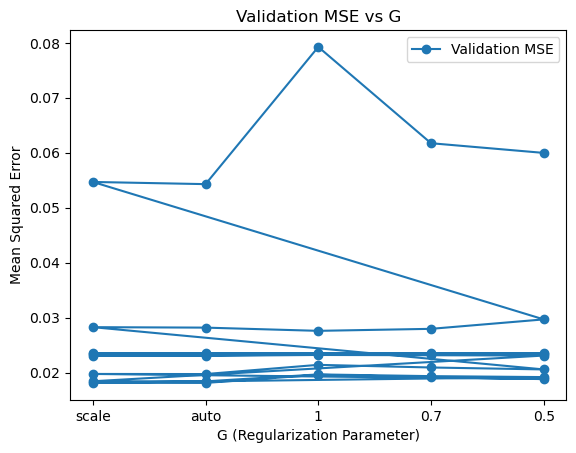

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the parameter grid for gamma and C
param_grid = {
    'C': [.000001,.0001,.001,0.1, 1, 10, 100, 1000],  # C from 0.1 to 1000
    'C': [.000001,.0001,.001,0.1, 1, 10, 100, 1000],  # C from 0.1 to 1000
    'gamma': ['scale', 'auto',1,.7,.5]  # gamma values, scale and auto are options
}

# Initialize the SVM model
svm_rbf = SVR()

# Perform GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svm_rbf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model (with optimized hyperparameters)
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate the performance on the test data (MSE or R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse}")
print(f"Test R2 Score: {r2}")

# Access cross-validation results
cv_results = grid_search.cv_results_

# Extract the validation MSE (GridSearchCV uses negative MSE, so negate the scores)
validation_mse = -cv_results['mean_test_score']

# Print the MSE for each parameter combination
print("Validation MSE for each parameter combination:")
for params, mse in zip(cv_results['params'], validation_mse):
    print(f"Parameters: {params}, Validation MSE: {mse}")

# Get the MSE for the best parameters
best_validation_mse = -grid_search.best_score_
print(f"Best Validation MSE: {best_validation_mse}")

# Calculate training MSE for comparison
y_train_pred = best_model.predict(X_train_scaled)
training_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training MSE: {training_mse}")

# Optional: Visualize the MSE for different values of C
C_values = [param['C'] for param in cv_results['params']]
g_values = [param['gamma'] for param in cv_results['params']]
plt.plot(g_values, validation_mse, label="Validation MSE", marker='o')
plt.xlabel("G (Regularization Parameter)")
plt.ylabel("Mean Squared Error")
#plt.xscale('log')  # Log scale for C values
plt.title("Validation MSE vs G")
plt.legend()
plt.show()


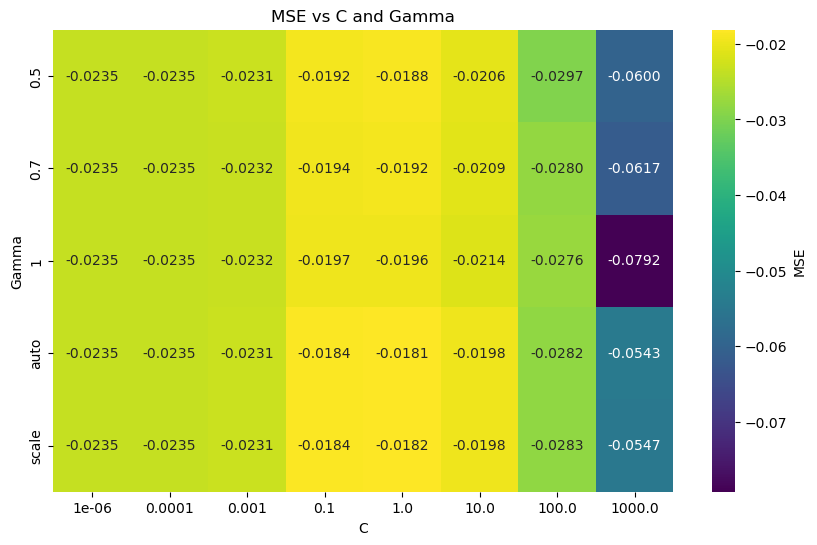

ValueError: could not convert string to float: 'scale'

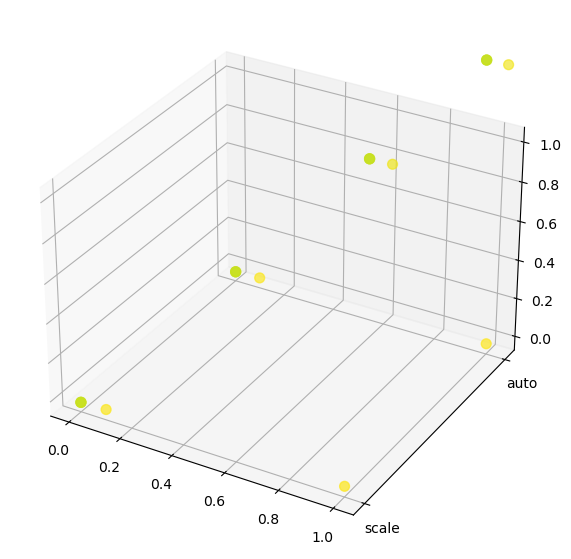

In [22]:
# Extract the results from the grid search
results = grid_search.cv_results_

# Get the values for C, gamma, and mean test score (MSE)
C_values = [param['C'] for param in results['params']]
gamma_values = [param['gamma'] for param in results['params']]
mse_values = results['mean_test_score']  # This assumes MSE is the scoring metric

# Create a DataFrame for easier manipulation (optional)
import pandas as pd
df = pd.DataFrame({
    'C': C_values,
    'Gamma': gamma_values,
    'MSE': mse_values
})

# Create a heatmap or contour plot for visualizing MSE as a function of C and Gamma

# Pivot the DataFrame to get MSE for different combinations of C and gamma
pivot_df = df.pivot(index='Gamma', columns='C', values='MSE')


# Plot using seaborn heatmap (2D)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'MSE'})
plt.title('MSE vs C and Gamma')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()

# If you prefer a 3D plot, here's how you can do it:

from mpl_toolkits.mplot3d import Axes3D

# Convert C_values and gamma_values into arrays for plotting
C_values = np.array(C_values)
gamma_values = np.array(gamma_values)
mse_values = np.array(mse_values)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(C_values, gamma_values, mse_values, c=mse_values, cmap='viridis', s=50)
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('MSE')
ax.set_title('MSE vs C and Gamma (3D)')

plt.show()

In [33]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Prepare the data
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
Y = Full_data_copy['Ecoli_GR']

# Split the data into training and test sets
X_Tmp, X_Test, Y_Tmp, Y_Test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=None, shuffle=True)

# Define the model
model = LGBMRegressor()

# Define the parameter grid for grid search
param_grid = {
    'num_leaves': [15],  # List of num_leaves values
    'max_depth': [2], 
    'learning_rate': np.arange(0.001, 0.053,.001),
}
param_grid2 = {
    'num_leaves': [2,4,8,10,16,15,20,24,26,30,32],  # Range from 2 to 24 with a step of 2
    'max_depth': np.arange(2, 16),  
    'min_split_gain': np.arange(0,.5,.01),
    'learning_rate': np.arange(0.001, 0.053,.001), #np.arange(0.01, 0.07, .005),  # 10 evenly spaced values between 0.01 and 0.1
    'n_estimators': np.arange(200, 600, 50),  # Range from 50 to 200 with a step of 50'num_leaves': [2,4,6,8,10,12,14,16,24],
    'min_child_samples': np.arange(5,20,1),
    'subsample': [0.8],
    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'subsample_freq': [2],
    'reg_alpha': np.arange(0,.25,0.01),
    'reg_lambda': np.arange(0,.25,0.01),
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_Tmp, Y_Tmp)

# Get the results from GridSearchCV
results = grid_search.cv_results_

# Extract the MSE values and num_leaves values
mse_values = -results['mean_test_score']  # Convert from negative MSE to positive MSE
num_leaves_values = results['param_num_leaves'].data
num_max_depth = results['learning_rate'].data
# Create a DataFrame for better visualization
df = pd.DataFrame({
    'learning_rate': num_max_depth,
    'MSE': mse_values
})

# Plot the MSE vs num_leaves
plt.figure(figsize=(10, 6))
sns.lineplot(x='learning_rate', y='MSE', data=df, marker='o', color='b')
plt.title('MSE vs learning_rate for LightGBM')
plt.xlabel('learning_rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32081
[LightGBM] [Info] Number of data points in the train set: 482, number of used features: 256
[LightGBM] [Info] Start training from score 0.760795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

KeyError: 'learning_rate'

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 482, number of used features: 8
[LightGBM] [Info] Start training from score 0.756804
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 482, number of used features: 8
[LightGBM] [Info] Start training from score 0.756804
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 482, number of used features: 8
[LightGBM] [Info] Start tra

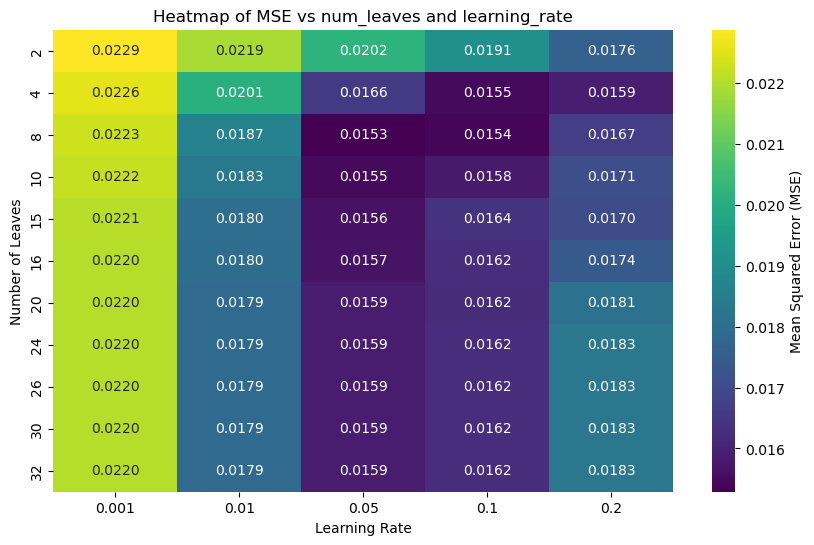

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Prepare the data
X = Full_data_copy.drop(columns=['run_accession', 'SubjectID_child', 'visitlabel', 'Ecoli_GR'])
Y = Full_data_copy['Ecoli_GR']

# Split the data into training and test sets
X_Tmp, X_Test, Y_Tmp, Y_Test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=2, shuffle=True)

#Feature selection inner cv 
rfr = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfr, n_estimators='auto', verbose=0, random_state=1)
boruta_selector.fit(np.array(X_Tmp), np.array(Y_Tmp))

select_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':boruta_selector.ranking_}).sort_values(by='Ranking')

#Get top and middle top features and make X_tmp matrix of only those features
Top_feature_columns = select_features[select_features['Ranking']==1].index   #get columns of top features(for sure)
median_ranking = np.median(boruta_selector.ranking_)
middle_features = select_features[(select_features['Ranking']<median_ranking)|(select_features['Ranking']<median_ranking+3)]
middle_features_columns = middle_features.index  #get features that were kinda top /from middle distribtion
X_Tmp_w_top_features = X_Tmp.iloc[:,Top_feature_columns]
X_Tmp_w_middle_features = X_Tmp.iloc[:,middle_features_columns]
X_Test_w_middle_features = X_Test.iloc[:,middle_features_columns]


# Define the model
model = LGBMRegressor()

# Define the parameter grid for grid search
param_grid = {
    'num_leaves': [2, 4, 8, 10, 16, 15, 20, 24, 26, 30, 32],  # Example values for num_leaves
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # Range of learning_rate values
    #'n_estimators': np.arange(200, 600, 50),
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_Tmp_w_top_features, Y_Tmp)

# Get the results from GridSearchCV
results = grid_search.cv_results_

# Extract the MSE values and learning_rate values
mse_values = -results['mean_test_score']  # Convert from negative MSE to positive MSE
learning_rate_values = results['param_learning_rate'].data
#n_estimator_values = results['n_estimators'].data

# Create a DataFrame to hold the results
df = pd.DataFrame({
    'num_leaves': num_leaves_values,
    'learning_rate': learning_rate_values,
    'MSE': mse_values
})

# Pivot the DataFrame to create a matrix for the heatmap
pivot_df = df.pivot_table(index='num_leaves', columns='learning_rate', values='MSE', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'Mean Squared Error (MSE)'})
plt.title('Heatmap of MSE vs num_leaves and learning_rate')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Leaves')
plt.show()

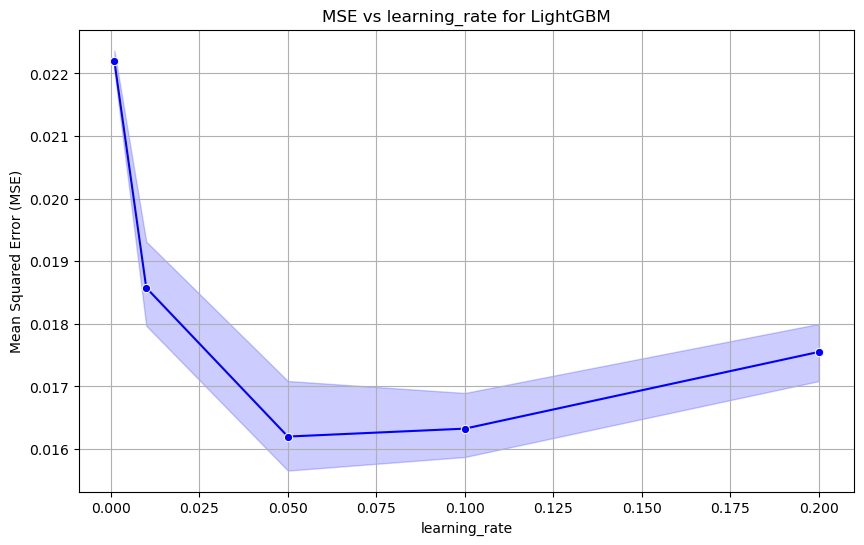

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [47]:
# Plot the MSE vs num_leaves
plt.figure(figsize=(10, 6))
sns.lineplot(x='learning_rate', y='MSE', data=df, marker='o', color='b')
plt.title('MSE vs learning_rate for LightGBM')
plt.xlabel('learning_rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


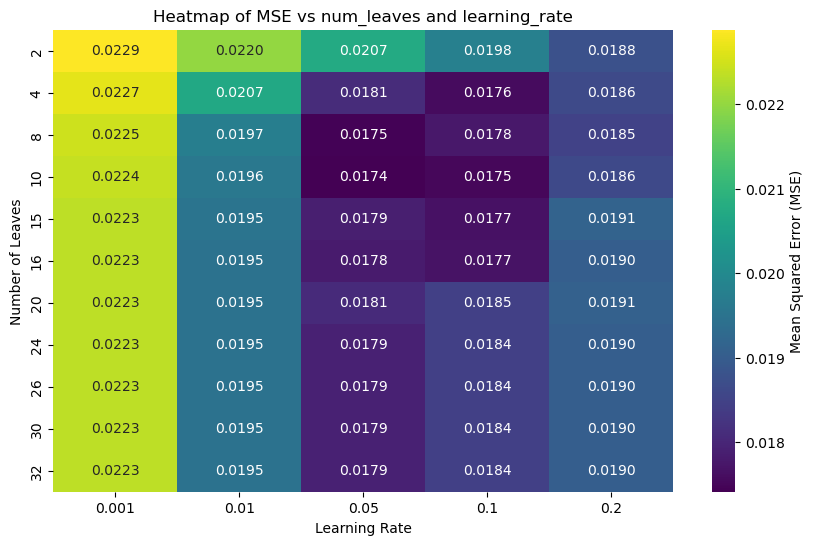

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31662
[LightGBM] [Info] Number of data points in the tra

In [38]:
# Extract the MSE values, num_leaves, and learning_rate values
mse_values = -results['mean_test_score']  # Convert from negative MSE to positive MSE
num_leaves_values = results['param_num_leaves'].data
learning_rate_values = results['param_learning_rate'].data

# Create a DataFrame to hold the results
df = pd.DataFrame({
    'num_leaves': num_leaves_values,
    'learning_rate': learning_rate_values,
    'MSE': mse_values
})

# Pivot the DataFrame to create a matrix for the heatmap
pivot_df = df.pivot_table(index='num_leaves', columns='learning_rate', values='MSE', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'Mean Squared Error (MSE)'})
plt.title('Heatmap of MSE vs num_leaves and learning_rate')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Leaves')
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


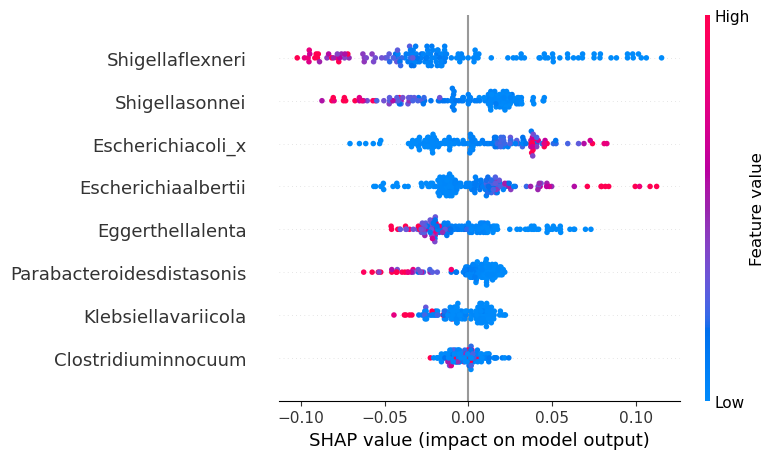

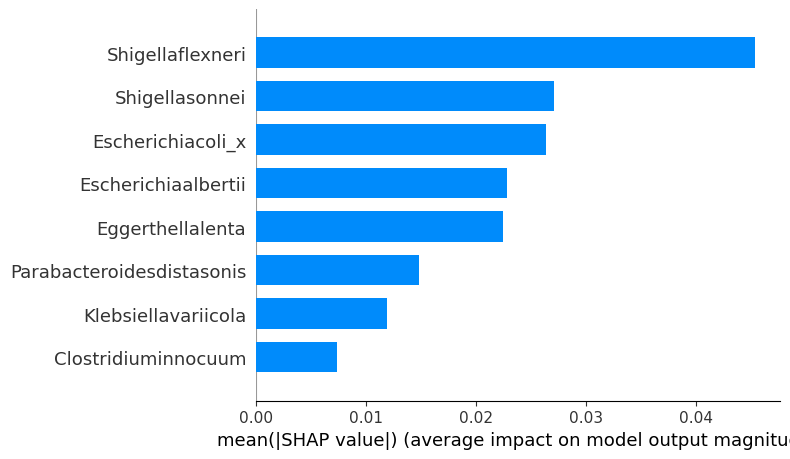

Test Score (MSE) of the Best Model: 0.015363910815449869


In [50]:
# Assuming `grid_search` has already been performed
best_model = grid_search.best_estimator_  # The best model from grid search
X_Test_w_Top_features = X_Test.iloc[:,Top_feature_columns]
# Make predictions on the test set
Y_pred = best_model.predict(X_Test_w_Top_features)


# Compute SHAP values for the real model
explainer_real = shap.Explainer(best_model)  # Create a SHAP explainer
shap_values_real = explainer_real(X_Test_w_Top_features)  # Calculate SHAP values



        #shap_results_data_to_save = {
        #'shap_values': shap_values_real.values,    # these are SHAP values for each feature for the test set
        #'test_indices': Test_indices   # these are Test indices used in this split
        #}
# Plot the summary plot for global feature importance
shap.summary_plot(shap_values_real, X_Test_w_Top_features)

# Plot the feature importance plot (optional)
shap.summary_plot(shap_values_real, X_Test_w_Top_features, plot_type="bar")



# Calculate the test score (Mean Squared Error in this case)
test_score = mean_squared_error(Y_Test, Y_pred)

print(f"Test Score (MSE) of the Best Model: {test_score}")

In [51]:
r2_test_score = r2_score(Y_Test, Y_pred)
print(f"Test R² Score of the Best Model: {r2_test_score}")

Test R² Score of the Best Model: 0.35824864779352594
